# 三子指标统一做图

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)


# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(cfg.db.perfectures)

# 水库库容数据
reservoirs_capacity = pd.read_csv(cfg.db.reservoirs, index_col=0)

# 水库库容累积相加数据
reservoirs_capacity_cumulating = reservoirs_capacity.cumsum()
consumptions = pd.read_csv(cfg.db.consumptions)

# 加载径流和水库数据
use_cols = {
    "唐乃亥": "SR",  # 唐乃亥控制源区
    "头道拐": "UR",  # 头道拐控制上游
    "花园口": "MR",  # 花园口控制中游
    "利津": "DR",  # 利津控制下游
}
# 径流数据
measured_runoff = pd.read_csv(cfg.db.runoff, index_col="年份")
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

Text(0, 0.5, 'Allocation indicator (IA)')

Text(0.5, 0, 'Year')

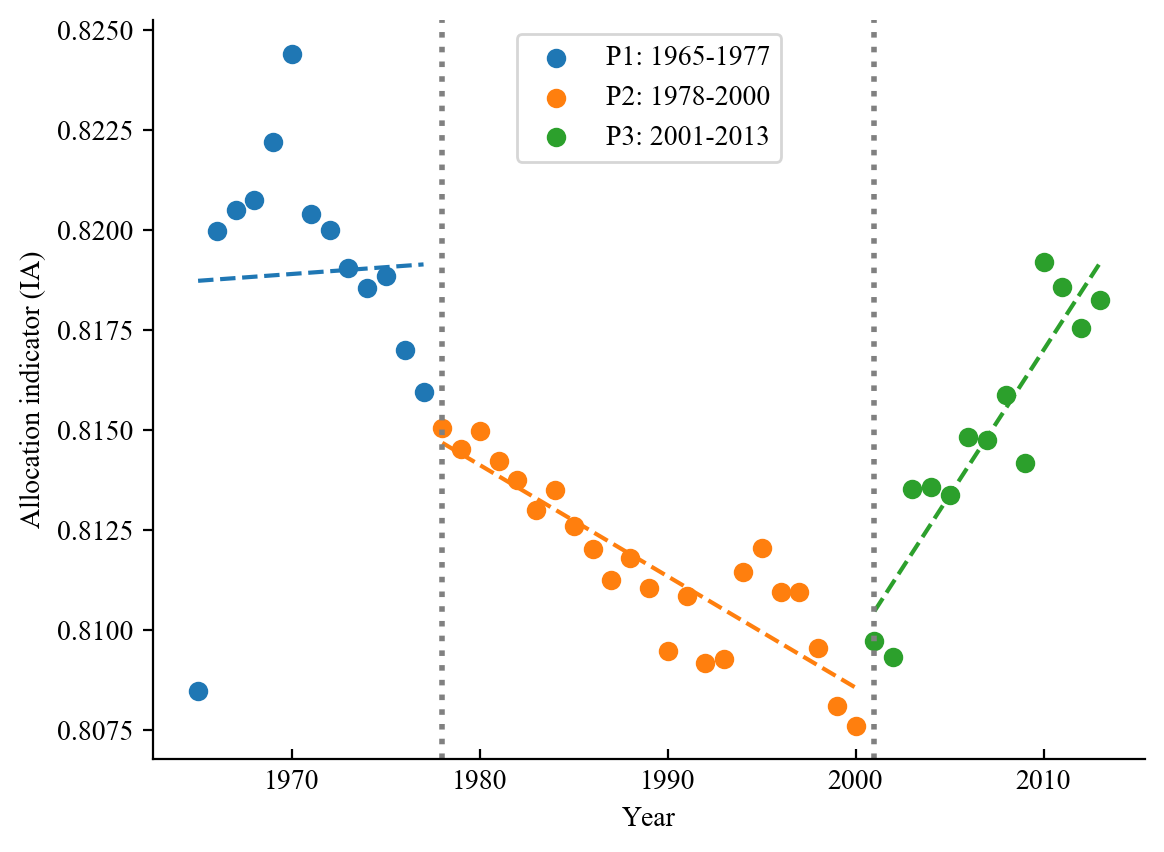

In [2]:
from regimes_yrb.allocation import calc_regional_entropy
from regimes_yrb.plot import plot_data
from regimes_yrb.tools.statistic import norm_zscore
from mksci_font import config_font
from regimes_yrb.plot import plot_pettitt_change_points
from matplotlib import pyplot as plt

config_font()
allocation = calc_regional_entropy(city_yr)

ax1 = plot_pettitt_change_points(
    allocation,
    change_points=cfg.breakpoints,
    returns="ax",
)
ax1.set_ylabel("Allocation indicator (IA)")
# ax1.set_ylabel("分配方式")
# ax1.set_xlabel("年份")
ax1.set_xlabel("Year")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

In [3]:
from regimes_yrb.scarcity import calc_sfv

# 计算 SFV
sfv, sfv_regions = calc_sfv(
    measured_runoff,
    consumptions,
    reservoirs_capacity_cumulating,
    cfg.inflexible_wu,
)

from regimes_yrb.tools.statistic import calc_contribution_ratio

contribution = pd.DataFrame()
for start, end in [
    (cfg.start, cfg.breakpoints[0]),
    (cfg.breakpoints[0], cfg.breakpoints[1]),
    (cfg.breakpoints[1], cfg.end),
]:
    contri = calc_contribution_ratio(sfv_regions.loc[start:end])
    contribution[f"{start}-{end}"] = contri


# 定义格式化函数
def percentage(x):
    return "{:.2%}".format(x)


# 应用格式化函数
formatted_df = contribution.style.format(percentage)
formatted_df
# 将结果保存为 LaTeX 格式的表
# formatted_df.to_latex('svf_regions_contribution.tex')

,1966-1978,1978-2001,2001-2013
SR,0.00%,0.00%,0.00%
UR,90.95%,89.94%,-5.28%
MR,9.05%,36.42%,123.86%
DR,-0.00%,-26.36%,-18.58%


In [19]:
from regimes_yrb.priority import direct_ratio

# 产生直接惠益的用水方式
direct = [
    "IRR",
    "Urban domestic WU",
    "Rural domestic WU",
    "Rural livestock WU",
]

# 产生间接惠益的用水方式
indirect = ["IND", "Urban service WU"]

# 数据是用水量，每年加总
data = city_yr.groupby("Year").sum(numeric_only=True)

# 计算比例
priority, priority_contributions = direct_ratio(
    data, indirect=indirect, direct=direct, breakpoints=cfg.breakpoints
)

# 数据导出
# 应用格式化函数
priority_contributions = priority_contributions.style.format(percentage)
priority_contributions
# 将结果保存为 LaTeX 格式的表
# priority_contributions.to_latex('priority_contributions.tex', index=True)

,P1: 1965-1977,P2: 1978-2000,P3: 2001-2013
Total,0.45%,-3.68%,-3.57%
Numerator,48.39%,14.92%,-7.25%
Denominator,-47.95%,-18.60%,3.68%
IRR,45.02%,13.59%,-6.11%
Urban domestic WU,1.03%,0.53%,-0.61%
Rural domestic WU,1.86%,0.61%,-0.37%
Rural livestock WU,0.48%,0.20%,-0.16%


## 合并做图

Text(0, 0.5, '稀缺情况')

Text(0.5, 0, '年份')

Text(0.06, 0.05, 'A')

Text(0, 0.5, '使用目的')

Text(0.5, 0, '年份')

Text(0.06, 0.05, 'B')

Text(0, 0.5, '分配方式')

Text(0.5, 0, '年份')

Text(0.06, 0.05, 'C')

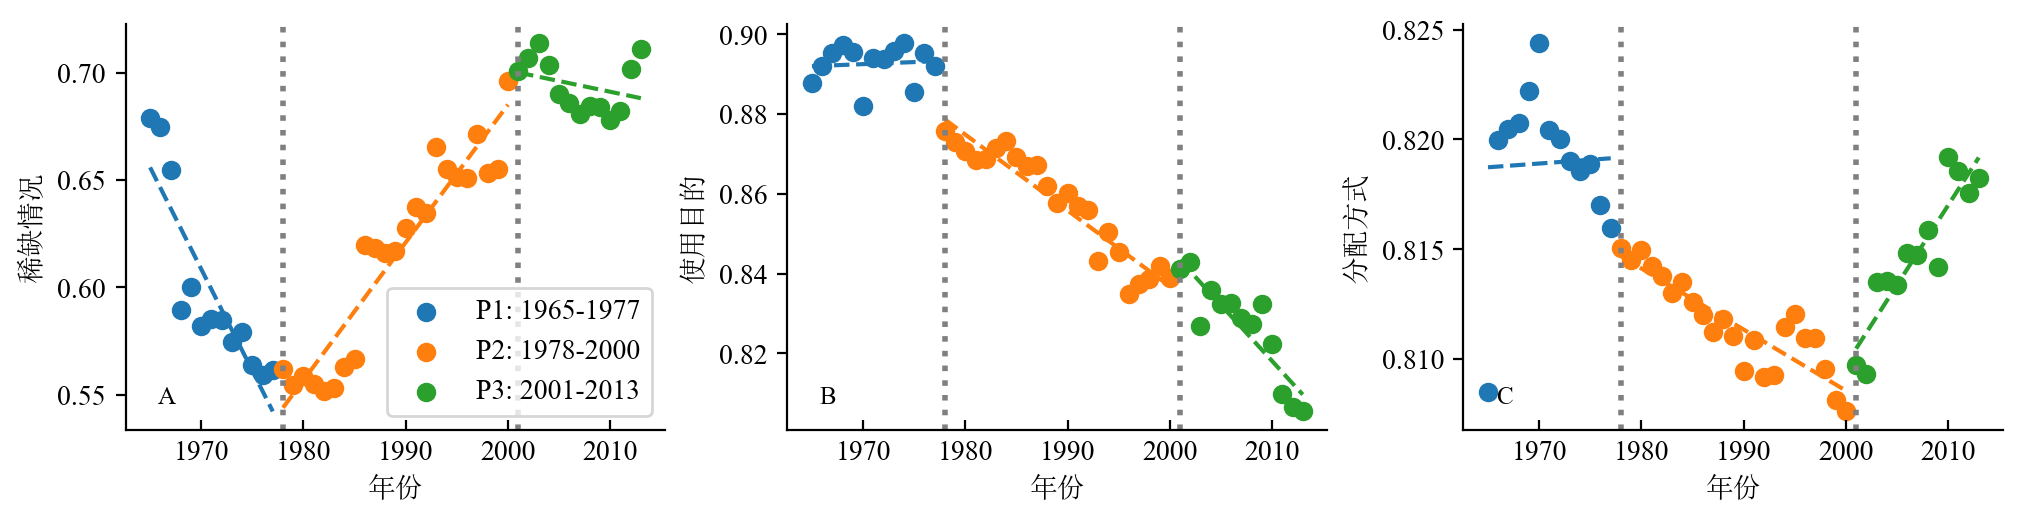

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), constrained_layout=True)


for i, indicator in enumerate([sfv, priority, allocation]):
    ax = plot_pettitt_change_points(
        indicator,
        change_points=cfg.breakpoints,
        ax=axs[i],
        returns="ax",
    )
    ax.set_ylabel(["稀缺情况", "使用目的", "分配方式"][i])
    # ax1.set_ylabel("分配方式")
    # ax1.set_xlabel("年份")
    ax.set_xlabel("年份")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.text(
        0.06,
        0.05,
        ["A", "B", "C"][i],
        transform=ax.transAxes,
        verticalalignment="bottom",
        horizontalalignment="left",
        fontsize=9,
    )
    if i > 0:
        axs[i].legend(handles=[], frameon=False)


# 保存
plt.savefig("figures/sup/indicators.png", dpi=300)